<h2> Download necessary libraries </h2>

In [259]:

#!conda install -c anaconda lxml --yes
#!conda install -c anaconda xlrd --yes
#!pip install BeautifulSoup4
#!pip install requests
#!pip install wget
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes 
#!pip install geocoder

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\sgupta\Anaconda3

  added / updated specs:
    - lxml


The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.8.3-py37hc8dfbb8~ --> anaconda::conda-4.8.3-py37_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


<h2> Make all necessary Imports </h2>

In [261]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Imports completed')

Imports completed


<h2> Get Toronto Data </h2>

In [6]:
path  = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(path)

df = pd.read_html(path, header=0, na_values = ['Not assigned'])[0]
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


<h2> Cleanup Data </h2>

In [23]:
#Drop NaN records
df.dropna(subset=['Borough'], inplace=True)

#Replace empty Neighborhood with Borough Data
df['Neighborhood'].fillna(df['Borough'], inplace=True)
empty_hood = df[df['Neighborhood'].isna()].shape[0]
print('Check Empty Neighborhood Records: {}'.format(empty_hood))
#df.head(10)
print('Data size is:',toronto_df.shape)

#Separate Neighborhoods using comma & group by Postal Codes, then Borough
toronto_df =pd.DataFrame( df.groupby(['Postal Code','Borough']).Neighborhood.agg([('Neighborhood', ', '.join)]))
toronto_df.reset_index(inplace=True)
toronto_df.head(10)




Check Empty Neighborhood Records: 0
Data size is: (103, 3)


,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


<h2> Get Geo Data </h2>

In [24]:
geo_path = 'http://cocl.us/Geospatial_data'
df_coord = pd.read_csv(geo_path)
df_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


<h2> Merge Postal Codes Dataframe with Latituge/Longitude Data </h2>

In [27]:
toronto_hoods = pd.merge(toronto_df, df_coord, on='Postal Code')
toronto_hoods.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<h2> Plot the Map of Toronto with the Neighborhoods </h2>

In [262]:
# create map of Toronto using first entries latitude and longitude values
map_toronto = folium.Map(location=[toronto_hoods["Latitude"][0], toronto_hoods["Longitude"][0]], zoom_start=10)

# add Borough abd Neighborhood markers to map
for lat, lng, borough, neighborhood in zip(toronto_hoods['Latitude'], toronto_hoods['Longitude'], toronto_hoods['Borough'], toronto_hoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<h2> For Displaying on GitHub </h2>

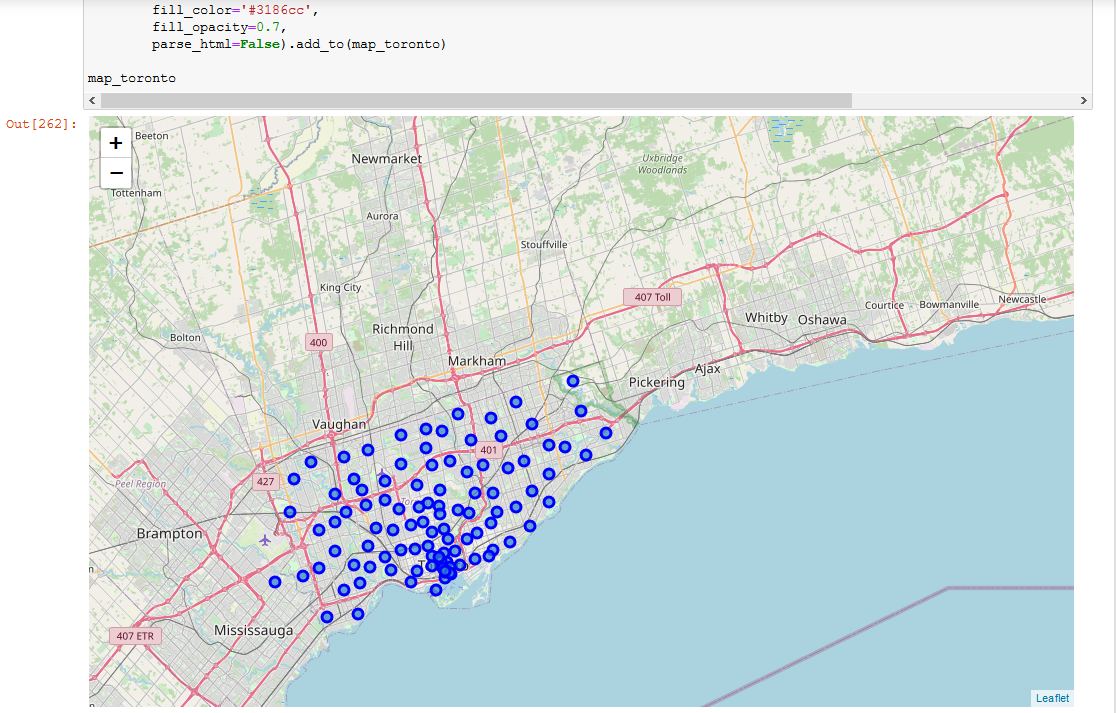

In [263]:
from IPython.display import Image
Image(filename='final_1.png') 

<h2> Setup FourSquare Credentials </h2>

In [37]:
CLIENT_ID = 'LFMNUAIN0PBILSX2JQKVCXNHDOQWCHJC20ENRWTD2OL5O2SG' # your Foursquare ID
CLIENT_SECRET = 'CELNFYGFD5CHN00KU5JRDGSIYBJQH025FA5B0SL3QQW4DNVT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

<h2> Function for getting nearby Venues </h2>

In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
   
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h2> Retreive and Store Venues </h2>

In [129]:
#toronto_venues = getNearbyVenues(names=toronto_hoods['Neighborhood'],latitudes=toronto_hoods['Latitude'],longitudes=toronto_hoods['Longitude'])
print('size of venues dataset :  ',toronto_venues.shape)
toronto_venues.head()


size of venues dataset :   (684, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern, Rouge",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


<h2> Onehot Encoding of Venues</h2>

In [142]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[cols]

toronto_onehot = toronto_onehot.groupby('Neighborhood').mean().reset_index()

print(toronto_onehot.shape)
toronto_onehot.head()

(96, 177)


,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Store,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Lounge,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Noodle House,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Pool,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tea Room,Tennis Court,Thai Restaurant,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.25,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.142857,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst M

<h2> Get or Venue of Interest (Coffee Shops) to perform Clustering </h2>

In [159]:
coffee_shops = toronto_onehot[["Neighborhood","Coffee Shop"]]
print(coffee_shops.shape)
coffee_shops.head()

(96, 2)


,Neighborhood,Coffee Shop
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.142857
2,"Bathurst Manor, Wilson Heights, Downsview North",0.200000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.100000


<h2> Find the best value for K </h2>

In [174]:
venue_clustering= coffee_shops.drop('Neighborhood', 1)

for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster).fit(venue_clustering)
    label = kmeans.labels_
    sil_score = silhouette_score(venue_clustering, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_score))

For n_clusters=2, The Silhouette Coefficient is 0.7980885002794477
For n_clusters=3, The Silhouette Coefficient is 0.867141013857219
For n_clusters=4, The Silhouette Coefficient is 0.9286227540784832
For n_clusters=5, The Silhouette Coefficient is 0.9267626350308641
For n_clusters=6, The Silhouette Coefficient is 0.961641589506173
For n_clusters=7, The Silhouette Coefficient is 0.9610532407407405
For n_clusters=8, The Silhouette Coefficient is 0.9583333333333334
For n_clusters=9, The Silhouette Coefficient is 0.9583333333333334


C:\Users\sgupta\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.


<h2> Perform K Means Clustering </h2>

In [222]:
# k=6 has the highest silhoutte coeff
kclusters = 6
toronto_clustered = coffee_shops.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1)
kmeans.fit_transform(toronto_clustered)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:20]

# copy dataset add clustering labels
toronto_coffee = coffee_shops.copy()
toronto_coffee["Cluster Labels"] = kmeans.labels_

print(toronto_coffee.shape)
toronto_coffee.head()

(96, 3)


,Neighborhood,Coffee Shop,Cluster Labels
0,Agincourt,0.000000,1
1,"Alderwood, Long Branch",0.142857,5
2,"Bathurst Manor, Wilson Heights, Downsview North",0.200000,4
3,Bayview Village,0.000000,1
4,"Bedford Park, Lawrence Manor East",0.100000,0


<h2> Merge the Location Data with the Clustered Data </h2>

In [252]:
#merge the dataframes

toronto_merged=pd.merge(toronto_coffee.set_index('Neighborhood'),toronto_venues, on='Neighborhood')
#toronto_merged.drop(toronto_merged[toronto_merged['Venue Category'] != "Coffee Shop"].index, inplace=True)

print(toronto_merged.shape)
toronto_merged.head()

(684, 9)


,Neighborhood,Coffee Shop,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.000000,1,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
1,Agincourt,0.000000,1,43.794200,-79.262029,Twilight,43.791999,-79.258584,Lounge
2,Agincourt,0.000000,1,43.794200,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
3,Agincourt,0.000000,1,43.794200,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink
4,"Alderwood, Long Branch",0.142857,5,43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place


<h2> Plot the Map of the Clustered Data for Coffee Shops </h2>

In [253]:
lat = 43.651070
long = -79.347015
map_clusters = folium.Map(location=[lat, long],zoom_start=14)

# add colors to identify clusters 
markers_colors={}
markers_colors[0] = 'red'
markers_colors[1] = 'blue'
markers_colors[2] = 'green'
markers_colors[3] = 'yellow'
markers_colors[4] = 'purple'
markers_colors[5] = 'black'

# add markers to the map
for lat, lon, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], toronto_merged['Cluster Labels']):
    
    
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        color =markers_colors[cluster],
        fill = True,
        fill_color=markers_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h2> For Displaying Cluster Plot/Map on GitHub  </h2>

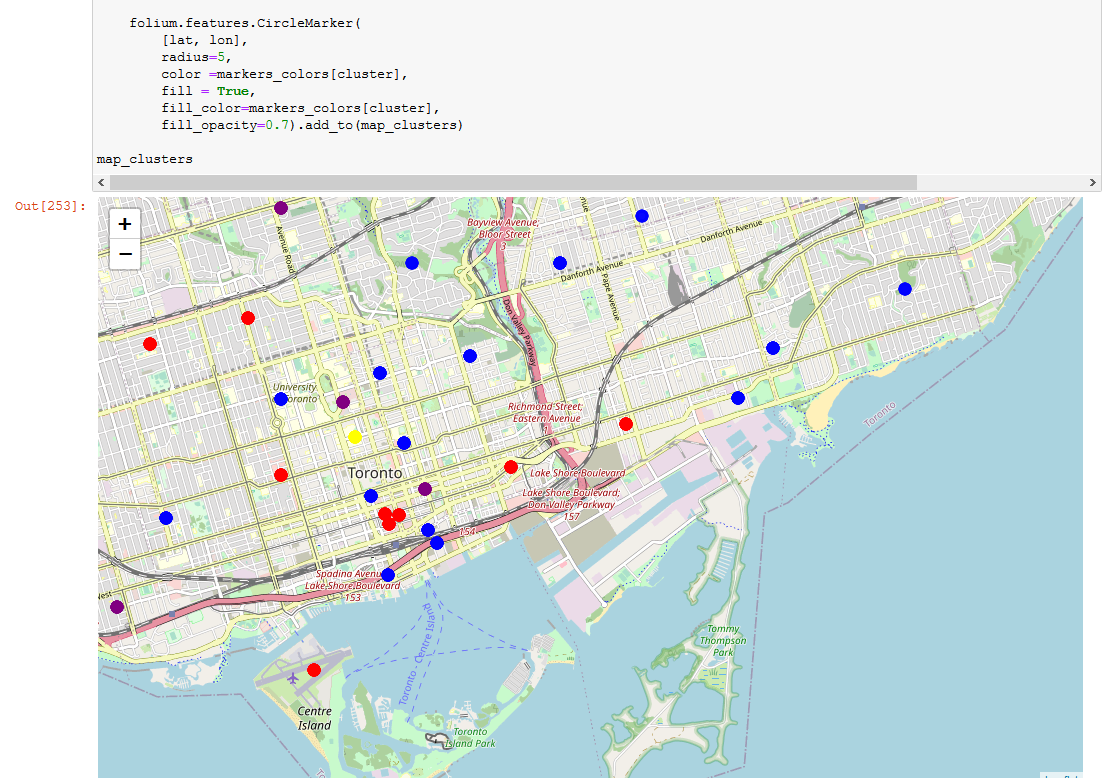

In [264]:
from IPython.display import Image
Image(filename='final_2.png') 

<h2> Lets see how many coffee shops each cluster has </h2>

In [254]:
print(toronto_merged.loc[(toronto_merged['Cluster Labels'] ==0) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)
print(toronto_merged.loc[(toronto_merged['Cluster Labels'] ==1) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)
print(toronto_merged.loc[(toronto_merged['Cluster Labels'] ==2) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)
print(toronto_merged.loc[(toronto_merged['Cluster Labels'] ==3) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)
print(toronto_merged.loc[(toronto_merged['Cluster Labels'] ==4) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)
print(toronto_merged.loc[(toronto_merged['Cluster Labels'] ==5) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)



(21, 9)
(0, 9)
(2, 9)
(4, 9)
(14, 9)
(4, 9)


<h2> Lets view cluster 0 as it has the most coffeee shops </h2>

In [255]:
cluster0=toronto_merged.loc[(toronto_merged['Cluster Labels'] ==0) & (toronto_merged['Venue Category'] == 'Coffee Shop')]
#cluster0.groupby('Neighborhood').sum()
cluster0


,Neighborhood,Coffee Shop,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
31,"Bedford Park, Lawrence Manor East",0.100000,0,43.733283,-79.419750,Tim Hortons,43.735356,-79.419605,Coffee Shop
76,"CN Tower, King and Spadina, Railway Lands, Har...",0.100000,0,43.628947,-79.394420,Balzac’s Coffee Roasters,43.631392,-79.395952,Coffee Shop
115,Christie,0.100000,0,43.669542,-79.422564,Starbucks,43.671530,-79.421400,Coffee Shop
147,"Commerce Court, Victoria Hotel",0.100000,0,43.648198,-79.379817,Pilot Coffee Roasters,43.648835,-79.380936,Coffee Shop
162,Davisville,0.100000,0,43.704324,-79.388790,Starbucks,43.705923,-79.389548,Coffee Shop
190,Don Mills,0.071429,0,43.725900,-79.340923,Tim Hortons,43.722897,-79.339117,Coffee Shop
246,"First Canadian Place, Underground city",0.100000,0,43.648429,-79.382280,Pilot Coffee Roasters,43.648835,-79.380936,Coffee Shop
329,"Kennedy Park, Ionview, East Birchmount Park",0.111111,0,43.727929,-79.262029,Tim Hortons,43.726895,-79.266157,Coffee Shop
345,"Kensington Market, Chinatown, Grange Park",0.100000,0,43.653206,-79.400049,Little Pebbles,43.654883,-79.400264,Coffee Shop
355,"Lawrence Manor, Lawrence Heights",0.100000,0,43.718518,-79.464763,Tim Hortons,43.719427,-79.467995,Coffee Shop


<h2> Lets view cluster 1 Neighborhoods as this have no Coffee Shops </h2>

In [257]:
cluster1=toronto_merged.loc[(toronto_merged['Cluster Labels'] ==1)]
#cluster0.groupby('Neighborhood').sum()
cluster1.head(10)


,Neighborhood,Coffee Shop,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,1,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
1,Agincourt,0.0,1,43.794200,-79.262029,Twilight,43.791999,-79.258584,Lounge
2,Agincourt,0.0,1,43.794200,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
3,Agincourt,0.0,1,43.794200,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink
21,Bayview Village,0.0,1,43.786947,-79.385975,Sun Star Chinese Cuisine 翠景小炒,43.787914,-79.381234,Chinese Restaurant
22,Bayview Village,0.0,1,43.786947,-79.385975,TD Canada Trust,43.788074,-79.380367,Bank
23,Bayview Village,0.0,1,43.786947,-79.385975,Maxim's Cafe and Patisserie,43.787863,-79.380751,Café
24,Bayview Village,0.0,1,43.786947,-79.385975,Kaga Sushi,43.787758,-79.381090,Japanese Restaurant
35,Berczy Park,0.0,1,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
36,Berczy Park,0.0,1,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant


<h1> Conclusion </h1>

<h2>1. Cluster 0 Neighborhoods has the maximum coffee shops to live around. </h2>

<h2>2. Cluster 4 Neighborhood has the second most coffee shops to live around. </h2>

<h2>3. Cluster 1 can do with some coffee shops, around Neighborhoods like Agincourd, Bayview Village & Berczy Park. </h2>


